Deterministic SIR model:

\begin{eqnarray}
\frac{dS}{dt} &=& -aS\frac{I}{N}\\
\frac{dI}{dt} &=& aS\frac{I}{N} - bI\\
\frac{dR}{dt} &=& bI
\end{eqnarray}

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# The SIR model differential equations.
def SIRdot(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I/N 
    dIdt = a * S * I/N  - b * I
    dRdt = b * I
    
    return dSdt, dIdt, dRdt


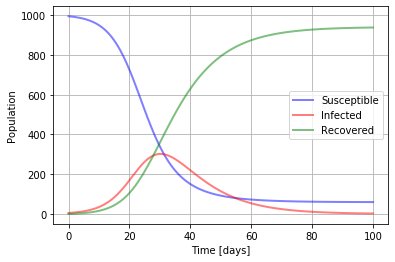

In [3]:
# Total population, N.
N = 1000
I0 = 5
R0 = 0
S0 = N - I0 - R0

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
a = 0.3
b = 0.1

# A grid of time points (in days)
T = 100
dt = 1
Nt = np.int(T/dt)+1
t = np.linspace(0, T, Nt)

# Initial conditions vector
Y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
sol = odeint(SIRdot, Y0, t, args=(N, a, b))
S, I, R = sol.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
plt.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
#plt.ylim(0,1.2)
plt.grid() 
plt.legend()


Reproduction number: $Ro = \frac{aN}{S(0)b}$

In [4]:
a*N/Y0[0]/b #reproduction number

3.015075376884422

# Stochastic SIR 

Here let's use the Gillespie algorithm to solve a stochastic version of SIR.  The probability in time interval $t$ to $t+\delta t$ of infection is 

$$p_\text{infection} = a (I/N) \delta t,$$ 

and the probability for removal in the same interval is 

$$p_\text{removal} = b \delta t.$$  

Noting that both probabilities are less than 1, we decide whether an event occurs by selecting a random number $r\in [0,1)$ and comparing this to each event probability.  Specifically, for susceptible person $i$, if $p_\text{infection}<r$, we say that person has become infected, and so the number of suceptibles $S$ decreases by 1, and the number of infectives $I$ increases by 1:

$$r<p_\text{infection} \quad\Rightarrow\quad S\rightarrow S-1, \quad I\rightarrow I+1.$$

We do a similar test for each infective person $j$.  

In [5]:
def SIRstep(N,S,I,R,a,b,dt):
    for i in range(S):
        if np.random.random_sample() < a*I*dt/N:
            S, I = S-1, I+1
    for i in range(I):
        if np.random.random_sample() < b*dt:
            I, R = I-1, R+1
            
    return S, I, R

In [6]:
# Solve stochastic SIR with same parameters and initial condition
S, I, R = S0, I0, R0
X = [[S, I, R]]     # X is a list

for i in range(Nt-1):
    S, I, R = SIRstep(N,S,I,R,a,b,dt)
    X = X + [[S,I,R]]   # Append to list
    
X = np.asarray(X)   # Convert to numpy array
Sd = X[:,0]
Id = X[:,1]
Rd = X[:,2]


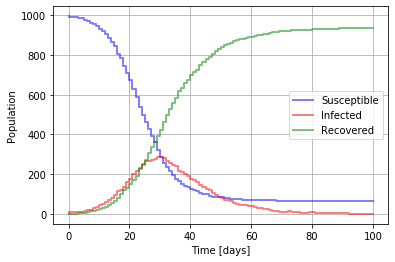

In [7]:
fig = plt.figure(facecolor='w')
plt.step(t, Sd, 'b',  alpha=0.5, lw=2, label='Susceptible')
plt.step(t, Id, 'r',  alpha=0.5, lw=2, label='Infected')
plt.step(t, Rd, 'g',  alpha=0.5, lw=2, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population')
plt.grid()
plt.legend()

# Parameter estimation using the Gauss-Newton method

Let's see if we can extract the deterministic parameters from the stochastic model output for $I(t_i) = I_i$, using Gauss-Newton.  

Starting with initial parameter guess $[a_0,b_0]$, compute an initial model solution $\tilde{I}(t,a_0,b_0)$ using the deterministic solver. Also compute four more solutions: 

$$\tilde{I}(t,a_0+\delta a,b_0), \quad 
  \tilde{I}(t,a_0-\delta a,b_0), \quad
  \tilde{I}(t,a_0,b_0+\delta b), \quad
  \tilde{I}(t,a_0,b_0-\delta b)$$
 
with $\delta a = a_0/10$ and $\delta b = b_0/10$ as a first try.
  
Use these solutions to compute the parameter gradients 

\begin{align}
\frac{\partial I}{\partial a} &= \frac{\tilde{I}(t,a_0+\delta a,b_0)-\tilde{I}(t,a_0-\delta a,b_0)}{2\delta a}\\
\frac{\partial I}{\partial b} &= \frac{\tilde{I}(t,a_0,b_0+\delta b)-\tilde{I}(t,a_0,b_0-\delta b)}{2\delta b}
\end{align}

For Gauss-Newton, we find solve a least squares problem to minimize a cost function between the data and current model guess, and iterate until the parameters have (hopefully) converged.  Define the first parameter guess $\theta_j^{(0)}$, where $\theta_1^{(0)} = a_0$, $\theta_2^{(0)} = b_0$.   Iterate $k$ is then $\theta_j^{(k)}$.  The Jacobian for iterate $k$ is $J_{ij}^{(k)} = \partial\tilde{I}_i/\partial\theta_j^{(k)}$, where $\tilde{I}_i^{(k)} = \tilde{I}(t_i,\theta_1^{(k)},\theta_2^{(k)})$.  

Defining the column vectors $\mathbf{\Delta I} = I_i - \tilde{I}_i^{(k)}$ and $\mathbf{\Delta\theta} = \theta_j^{(k+1)}-\theta_j^{(k)}$, and the matrix $\mathsf{J} = J_{ij}^{(k)}$ (suppressing the index $k$ because the notation is getting crowded), we solve the \textit{Normal System}

$$\mathbf{\Delta\theta} = (\mathsf{J}^T\mathsf{J})^{-1}(\mathsf{J}^T \mathbf{\Delta I})$$

starting with $k=0$ and iterating until some tolerance is satisfied.  I will use $||\Delta\theta|| < 0.01$ as the condition.

In [12]:
def SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b):
    # Compute solution 5 times:  [a, b], [a+da,b], [a-da,b], [a, b+db], [a, b-db]
    # Then compute gradient wrt a, b, at each t
    Y0 = S0, I0, R0
    N = S0+I0+R0
    da = a/10
    db = b/10
    
    sol = odeint(SIRdot, Y0, t, args=(N, a, b))
    S, I, R = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a+da, b))
    Sap, Iap, Rap = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a-da, b))
    Sam, Iam, Ram = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a, b+db))
    Sbp, Ibp, Rbp = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a, b-db))
    Sbm, Ibm, Rbm = sol.T

    dIda = (Iap-Iam)/(2*da)
    dIdb = (Ibp-Ibm)/(2*db)
    
    #return S, I, R, dIda, dIdb
    return I, dIda, dIdb, S

In [13]:
def GaussIter(t, Idata, S0, I0, R0, a0, b0):
    tol = .01
    NiterMax = 50
    
    a, b = a0, b0
    Da, Db = 1, 1
    
    fig = plt.figure(facecolor='w')
    plt.plot(t, Idata, 'b.', label='Data')
    
    Niter = 0
    while np.sqrt((Da)**2+(Db)**2) > tol and Niter < NiterMax:
        Niter += 1
        It, dIda, dIdb, St = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b)
        DI = Idata-It
        J = np.vstack((dIda,dIdb)).T
        Da,Db = np.linalg.inv(J.T.dot(J)).dot(J.T.dot(DI))
        a = a+Da
        b = b+Db
        
        plt.plot(t, It, alpha=0.5, lw=2, label='Model fit')
        
    plt.xlabel('Time /days')
    plt.ylabel('Infected population')
    plt.grid()
    plt.legend()
    return It, a, b, Niter, dIda, dIdb, St

(0.31145453556234914, 0.11132385968939888, 4)

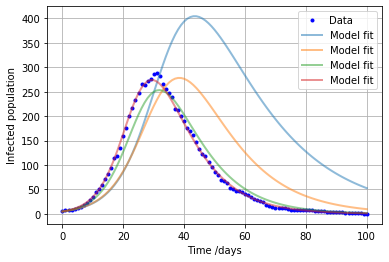

In [14]:
# Guess initial a, b (actual values are 0.3, 0.1)
N = 1000 # Maybe later this will be absorbed in a
a0 = .2
b0 = .05

#It, dIda, dIdb = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a0, b0)
It, at, bt, Niter, dIda, dIdb, St = GaussIter(t, Id, S0, I0, R0, a0, b0)
at, bt, Niter

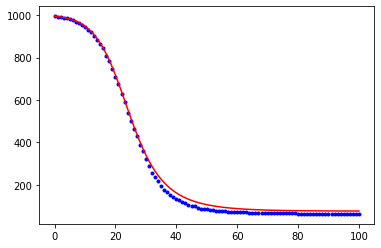

In [15]:
fig = plt.figure(facecolor='w')
plt.plot(t, Sd, 'b.', label='Data')
plt.plot(t, St, 'r', label='Data')


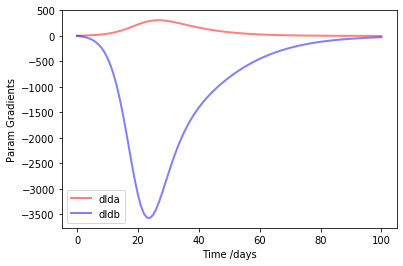

In [12]:
fig = plt.figure(facecolor='w')
plt.plot(t, It, 'r', alpha=0.5, lw=2, label='dIda')
plt.plot(t, dIdb, 'b', alpha=0.5, lw=2, label='dIdb')
plt.xlabel('Time /days')
plt.ylabel('Param Gradients')
plt.legend()